In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import cKDTree

In [2]:
plt.rcParams['font.size'] = 10  # Match 12pt document font size
plt.rcParams['font.weight'] = 400

plt.rcParams['savefig.bbox'] = 'tight' # borderles pdf
plt.rcParams['svg.fonttype'] = 'none'  # selectable text
plt.rcParams['ps.fonttype'] = 42       # selectable text

plt.rcParams['legend.fontsize'] = 10
plt.rcParams['legend.fancybox'] = False
plt.rcParams['legend.framealpha'] = 1
plt.rcParams['legend.edgecolor'] = 'black'

Defining constants in useful units:
- Energy: eV
- mass: atomic mass units (is converted to eV (fs/Å)²)
- Distance in Å
- time in fs

In [3]:
k_B = 8.617333262e-5  # Boltzmann constant in eV/K
mass = 157.25         # mass of Gd in u
u_to_eV = 1.036427e-4 # Conversion factor: 1 u = 1.036427e-4 eV (ps/Å)²

σ = 3.304   # in Angstrom
ϵ = 0.1136  # in eV

Setup the 3D crystal with dimensions of $x \times y \times z$ unit cells. The Gd atoms in a unit cell are positioned at
$$
r_1 = (1/4, 5/6, 1/4) \\
r_2 = (1/4, 1/6, 3/4) \\
r_3 = (3/4, 1/3, 1/4) \\
r_4 = (3/4, 2/3, 3/4)
$$
The dimensions of a single unit cell are given by $\left(a, \sqrt{3}a, \sqrt{\frac{3}{8}}a\right)$. The complete lattice is composed of 9x5x5 such unit cells (into a so-called supercell). The nearest neighbors are precomputed. Using the assumptions, that the atoms don't move a lot during the simulation, it is save to assume that this will not change

In [4]:
a = σ  # lattice parameter in Angstrom
ax, ay, az = a, np.sqrt(3) * a, np.sqrt(8/3) * a

# Basis atom positions (fractional coordinates)
basis_atoms = np.array([
    [1/4, 5/6, 1/4],
    [1/4, 1/6, 3/4],
    [3/4, 1/3, 1/4],
    [3/4, 2/3, 3/4]
])

In [5]:
def setup_Gd_crystal(Nx=9, Ny=5, Nz=5):
  lattice_points = []
  for i in range(Nx):
    for j in range(Ny):
      for k in range(Nz):
        translation = np.array([i * ax, j * ay, k * az])

        for atom in basis_atoms:
          lattice_points.append(translation + atom * [ax, ay, az])
          
  return np.array(lattice_points)

In [6]:
def find_nearest_neighbors(lattice, Nx=9, Ny=5, Nz=5, cutoff=10):
  # Apply periodic boundary conditions by considering shifts of neighboring cells
  translations = np.array([
    [dx, dy, dz] for dx in [-1, 0, 1] for dy in [-1, 0, 1] for dz in [-1, 0, 1]
  ])

  supercell_vectors = np.array([[Nx * ax, 0, 0], [0, Ny * ay, 0], [0, 0, Nz * az]])

  # Expand lattice with periodic images
  expanded_lattice = np.vstack([
    lattice + np.dot(shift, supercell_vectors)
    for shift in translations
  ])

  # use cKDTree as a very fast nearest-neighbor search algorithm. It uses indexing under the hood
  tree = cKDTree(expanded_lattice)
  neighbors_map = {}

  for i, atom in enumerate(lattice):
    neighbors = tree.query_ball_point(atom, cutoff)
    neighbors_map[i] = [n % len(lattice) for n in neighbors if (n%len(lattice)) != i]  # Map back to real indices

  return neighbors_map

In [7]:
lattice = setup_Gd_crystal()
nearest_neighbors = find_nearest_neighbors(lattice, cutoff=10)

Visualize the lattice. All atoms centered around a selected atom. Nearest neighbors are visualized in blue

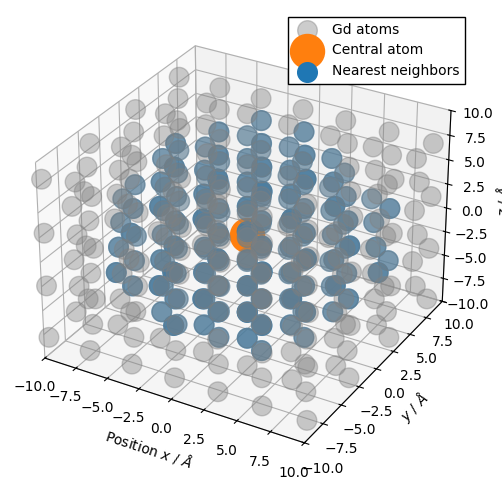

In [8]:
central_atom_idx = 532
box_size = 20

fig = plt.figure(figsize=(6, 6))
fig_ax = fig.add_subplot(111, projection='3d')

central_pos = lattice[central_atom_idx]
mid_x, mid_y, mid_z = central_pos

mask = np.all(
  (lattice > central_pos - box_size/2) & 
  (lattice < central_pos + box_size/2),
  axis=1
)

subset_indices = np.where(mask)[0]

fig_ax.scatter(lattice[subset_indices, 0] - mid_x, lattice[subset_indices, 1] - mid_y, lattice[subset_indices, 2] - mid_z, color='gray', alpha=0.4, s=200, label='Gd atoms')
fig_ax.scatter(0, 0, 0, color='C1', s=600, label='Central atom')

#show neighbors
neighbor_indices = nearest_neighbors[central_atom_idx]
neighbor_positions = lattice[neighbor_indices]
visible_neighbors = np.all(
  (neighbor_positions > central_pos - box_size/2) & 
  (neighbor_positions < central_pos + box_size/2),
  axis=1
)
visible_neighbor_positions = neighbor_positions[visible_neighbors]

fig_ax.scatter(visible_neighbor_positions[:, 0]-mid_x, 
  visible_neighbor_positions[:, 1]-mid_y, 
  visible_neighbor_positions[:, 2]-mid_z, 
  color='C0', s=200, label="Nearest neighbors")

fig_ax.set_xlabel('Position $x$ / $Å$')
fig_ax.set_ylabel('$y$ / $Å$')
fig_ax.set_zlabel('$z$ / $Å$')

max_range = box_size/2
    
fig_ax.set_xlim(-max_range, max_range)
fig_ax.set_ylim(-max_range, max_range)
fig_ax.set_zlim(-max_range, max_range)

fig_ax.grid(True)

# for top view
# fig_ax.view_init(elev=90, azim=0)

plt.legend()
plt.show()

Defining the **Lennard-Jones potential**
$$
V(\vec{x}) = \sum_{i \neq j}^{N} 4\epsilon \left[ \left(\frac{\sigma}{|\vec{x}_i - \vec{x}_j|}\right)^{12} - \left(\frac{\sigma}{|\vec{x}_i - \vec{x}_j|}\right)^6 \right]
$$
as the potential energy of the lattice

In [9]:
def lennard_jones_potential(r):
  return 4 * ϵ * ((σ/r)**12 - (σ/r)**6)

def lennard_jones_force(r):
  return 24 * ϵ * (2 * (σ/r)**12 - (σ/r)**6) / r

In [10]:
def F(positions, neighbors_map, Nx=9, Ny=5, Nz=5):
    """
    Calculate forces on all particles using Lennard-Jones potential with proper periodic boundary conditions.
    
    Parameters:
    - positions: Array of shape (num_particles, 3) with positions
    - neighbors_map: Dictionary mapping atom indices to neighbor indices
    - Nx, Ny, Nz: Supercell dimensions
    
    Returns:
    - forces: Array of shape (num_particles, 3) with forces (eV/Å)
    """
    num_particles = len(positions)
    forces = np.zeros((num_particles, 3))
    
    # Define supercell dimensions
    box_size = np.array([Nx * ax, Ny * ay, Nz * az])
    half_box = box_size / 2
    
    for i, neighbors in neighbors_map.items():
        pos_i = positions[i]
        
        for j in neighbors:
            pos_j = positions[j]
            
            # Calculate distance vector with minimum image convention
            r_ij = pos_i - pos_j
            
            # Apply minimum image convention for periodic boundary conditions
            for dim in range(3):
                if r_ij[dim] > half_box[dim]:
                    r_ij[dim] -= box_size[dim]
                elif r_ij[dim] < -half_box[dim]:
                    r_ij[dim] += box_size[dim]
            
            r = np.linalg.norm(r_ij)
            
            # Skip if atoms are at the same position (should not happen in a crystal)
            if r < 1e-10:
                continue
                
            force_mag = lennard_jones_force(r)
            force_vec = force_mag * r_ij / r
            
            forces[i] += force_vec
            # Don't apply Newton's third law here since we're iterating through all pairs
    
    return forces

def V(positions, neighbors_map, Nx=9, Ny=5, Nz=5):
    """
    Calculate the potential energy of all particles using Lennard-Jones potential with proper PBC.
    
    Parameters:
    - positions: Array of shape (num_particles, 3) with positions
    - neighbors_map: Dictionary mapping atom indices to neighbor indices
    - Nx, Ny, Nz: Supercell dimensions
    
    Returns:
    - total_energy: Total potential energy (eV)
    """
    total_energy = 0
    box_size = np.array([Nx * ax, Ny * ay, Nz * az])
    half_box = box_size / 2
    
    for atom_idx, neighbor_indices in neighbors_map.items():
        atom_pos = positions[atom_idx]
        atom_energy = 0
        
        for neighbor_idx in neighbor_indices:
            neighbor_pos = positions[neighbor_idx]
            
            # Calculate distance vector with minimum image convention
            r_vec = atom_pos - neighbor_pos
            
            # Apply minimum image convention for periodic boundary conditions
            for dim in range(3):
                if r_vec[dim] > half_box[dim]:
                    r_vec[dim] -= box_size[dim]
                elif r_vec[dim] < -half_box[dim]:
                    r_vec[dim] += box_size[dim]
            
            r = np.linalg.norm(r_vec)
            
            # Skip if atoms are at the same position (should not happen in a crystal)
            if r < 1e-10:
                continue
                
            pair_energy = lennard_jones_potential(r)
            atom_energy += pair_energy
        
        # Each pair is counted twice in the loop, so divide by 2
        atom_energy /= 2
        total_energy += atom_energy
    
    return total_energy

Setup the initial velocity of the lattice atoms. This is given (or assumed) by the **Maxwell-Boltzmann distribution**
$$
p(v_i) = \sqrt{\frac{m_i}{2 \pi k_B T}} e^{-\frac{m_i v_i^2}{2 k_B T}}
$$
The mass of Gd atoms $m_i = 157.25 \,\mathrm{u}$ and $k_B = 8.617333262 \times 10^{-5}\,\mathrm{eV/K}$. This is just a normal distribution around $\langle v_i \rangle=0$ and $\Delta v_i = \frac{k_B T}{m_i}$

In [20]:
def kinetic_energy(velocities):
  speed_sq = np.sum(velocities**2, axis=1)

  return 1/2 * (mass * u_to_eV) * np.sum(speed_sq)

def temperature(velocities):
  E_kin = kinetic_energy(velocities)
  return E_kin / (3/2 * len(velocities) * k_B)

In [ ]:
def maxwell_boltzmann(particle_number, T=300):
  velocities = np.zeros((particle_number, 3))

  scale = np.sqrt(k_B * T / (mass * u_to_eV))

  for i in range(3):
    velocities[:, i] = np.random.normal(0, scale, particle_number)
  
  # Remove any net momentum (center of mass motion) and rescale velocities accordingly
  E_kin_before = kinetic_energy(velocities)

  total_momentum = np.sum(velocities, axis=0)
  velocities -= total_momentum / particle_number

  E_kin_after = kinetic_energy(velocities)

  velocities *= np.sqrt(E_kin_before/E_kin_after)

  return velocities
  

In [27]:
T = 300
initial_velocities = maxwell_boltzmann(len(lattice), T)

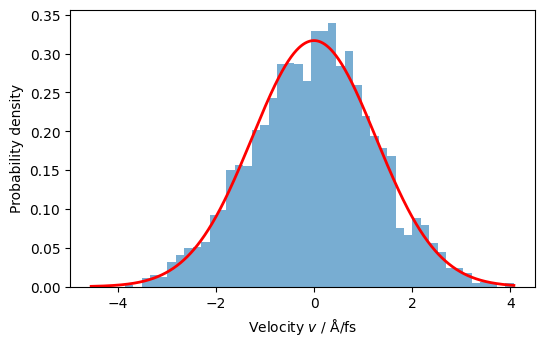

In [28]:
v_flattened = initial_velocities.flatten()

plt.figure(figsize=(6, 6*6/10))
plt.hist(v_flattened, bins=50, density=True, alpha=0.6, label='Simulation')

x = np.linspace(min(v_flattened), max(v_flattened), 1000)
scale = np.sqrt(k_B * T / (mass * u_to_eV))
plt.plot(x, np.exp(-x**2/(2*scale**2))/np.sqrt(2*np.pi*scale**2), 
             'r-', linewidth=2, label='Theoretical (Gaussian)')

plt.xlabel('Velocity $v$ / Å/fs')
plt.ylabel('Probability density')

plt.show()

Updating the velocity and the position of each atoms according to the extended 5-step verlet integration algorithm:
\begin{align}
p &\rightarrow e^{-\gamma \mathrm{d}t/2} p + \sqrt{m k_B T}\sqrt{1-e^{-\gamma \mathrm{d}t}}\xi_1 \\
p &\rightarrow p - \frac{\partial V}{\partial q} \frac{\mathrm{d}t}{2} \\
q &\rightarrow q + \frac{p}{m} \mathrm{d}t \\
p &\rightarrow p - \frac{\partial V}{\partial q} \frac{\mathrm{d}t}{2} \\
p &\rightarrow e^{-\gamma \mathrm{d}t/2} p + \sqrt{m k_B T}\sqrt{1-e^{-\gamma \mathrm{d}t}}\xi_2
\end{align}
where $\xi$ are small random forces and $\gamma$ are damping coefficients

In [39]:
def run_md_simulation(lattice, velocities, neighbors_map, gamma=0, T=300, dt=0.001, steps=1000, Nx=9, Ny=5, Nz=5):
  """
  Run a molecular dynamics simulation with the Velocity Verlet algorithm.

  Parameters:
    - lattice: Initial positions of atoms (Å)
    - velocities: Initial velocities of atoms (Å/ps)
    - neighbors_map: Dictionary mapping atom indices to neighbor indices
    - gamma: damping constant (1/ps)
    - dt: Time step (ps)
    - steps: Number of simulation steps
    - Nx, Ny, Nz: Supercell dimensions

  Returns:
    - trajectory: Array of shape (steps, num_particles, 3) with positions over time
    - velocities_history: Array of shape (steps, num_particles, 3) with velocities over time
    - energies: Dictionary with energy components over time
  """
  num_particles = len(lattice)
  box_size = np.array([Nx * ax, Ny * ay, Nz * az])

  trajectory = np.zeros((steps, num_particles, 3))
  velocities_history = np.zeros((steps, num_particles, 3))

  energies = {
    'kinetic': np.zeros(steps),
    'potential': np.zeros(steps),
    'total': np.zeros(steps),
    'temperature': np.zeros(steps)
  }

  # Set initial positions and velocities
  positions = lattice.copy()
  trajectory[0] = positions
  velocities_history[0] = velocities

  # Set initial energy
  E_kin = kinetic_energy(velocities)
  E_pot = V(positions, neighbors_map)
  energies['kinetic'][0] = E_kin
  energies['potential'][0] = E_pot
  energies['total'][0] = E_kin + E_pot
  energies['temperature'][0] = temperature(velocities)

  print(f"Beginning Simulation, T = {energies['temperature'][0]:.1f} K, E_total = {energies['total'][0]:.4f} eV")

  # Calculate initial forces
  forces = F(positions, neighbors_map, Nx, Ny, Nz)

  N, dim = np.shape(initial_velocities)

  for step in range(1, steps):
    # ====== Velocity Verlet integration ====
    # random normally distributed forces
    xi = np.random.normal(0, 1, (2, N, dim))

    velocities = np.exp(-gamma * dt/2)*velocities + np.sqrt(k_B * T / (mass * u_to_eV)) * np.sqrt(1 - np.exp(-gamma * dt)) * xi[0]

    velocities += forces / (mass * u_to_eV) * dt/2
    positions += velocities * dt

    # Apply periodic boundary conditions to keep particles within the box
    positions = positions % box_size

    forces = F(positions, neighbors_map, Nx, Ny, Nz)
    velocities += forces / (mass * u_to_eV) * dt/2

    velocities = np.exp(-gamma * dt/2)*velocities + np.sqrt(k_B * T / (mass * u_to_eV)) * np.sqrt(1 - np.exp(-gamma * dt)) * xi[1]


    trajectory[step] = positions
    velocities_history[step] = velocities

    # Calculate energies
    E_kin = kinetic_energy(velocities)
    E_pot = V(positions, neighbors_map, Nx, Ny, Nz)

    energies['kinetic'][step] = E_kin
    energies['potential'][step] = E_pot
    energies['total'][step] = E_kin + E_pot
    energies['temperature'][step] = temperature(velocities)

    if step % 25 == 0 or step == steps - 1:
      print(f"Step {step}/{steps-1}, T = {energies['temperature'][step]:.1f} K, E_total = {energies['total'][step]:.4f} eV")
  
  return trajectory, velocities_history, energies

In [30]:
trajectories, velocities_history, energies = run_md_simulation(lattice, initial_velocities, neighbors_map=nearest_neighbors, steps=400, dt=0.001, gamma=1)

Step 25/399, T = 161.8 K, E_total = -394.7923 eV
Step 50/399, T = 71.6 K, E_total = -393.8338 eV
Step 75/399, T = 155.3 K, E_total = -392.8179 eV
Step 100/399, T = 162.8 K, E_total = -392.1915 eV
Step 125/399, T = 176.0 K, E_total = -391.2307 eV
Step 150/399, T = 196.7 K, E_total = -390.2086 eV
Step 175/399, T = 155.7 K, E_total = -389.7912 eV
Step 200/399, T = 166.2 K, E_total = -388.9361 eV
Step 225/399, T = 188.0 K, E_total = -387.7698 eV
Step 250/399, T = 181.0 K, E_total = -387.1352 eV
Step 275/399, T = 199.0 K, E_total = -386.3629 eV
Step 300/399, T = 198.4 K, E_total = -385.5265 eV
Step 325/399, T = 187.2 K, E_total = -384.6946 eV
Step 350/399, T = 199.8 K, E_total = -383.4304 eV
Step 375/399, T = 197.2 K, E_total = -382.7880 eV
Step 399/399, T = 206.9 K, E_total = -382.2590 eV


Save the final position and velocity (and energies) for later computation. This is the state after the thermalization

In [40]:
trajectories, velocities_history, energies = run_md_simulation(trajectories[-1,:,:], velocities_history[-1,:,:], neighbors_map=nearest_neighbors, steps=400, dt=0.001, gamma=1)

Beginning Simulation, T = 206.9 K, E_total = -382.2590 eV
Step 25/399, T = 217.5 K, E_total = -381.6465 eV
Step 50/399, T = 202.6 K, E_total = -381.6009 eV
Step 75/399, T = 204.0 K, E_total = -381.2347 eV
Step 100/399, T = 214.8 K, E_total = -380.9942 eV
Step 125/399, T = 213.8 K, E_total = -381.2442 eV
Step 150/399, T = 218.0 K, E_total = -380.5480 eV
Step 175/399, T = 211.7 K, E_total = -379.7879 eV
Step 200/399, T = 217.8 K, E_total = -379.3517 eV
Step 225/399, T = 232.5 K, E_total = -379.1554 eV
Step 250/399, T = 218.6 K, E_total = -378.9187 eV
Step 275/399, T = 214.6 K, E_total = -378.3639 eV
Step 300/399, T = 229.7 K, E_total = -377.7330 eV
Step 325/399, T = 231.4 K, E_total = -377.4704 eV
Step 350/399, T = 228.2 K, E_total = -377.1905 eV
Step 375/399, T = 221.9 K, E_total = -376.7669 eV
Step 399/399, T = 232.0 K, E_total = -376.1407 eV


In [ ]:
thermalized_data = np.hstack((trajectories[-1,:,:], velocities_history[-1,:,:]))
np.savetxt("thermalized_state_800fs_gamma_1.csv", thermalized_data, delimiter=",", header="x,y,z,vx,vy,vz", comments='')

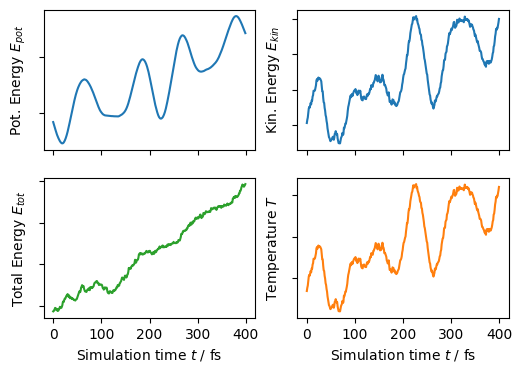

In [41]:
steps = len(trajectories)
time = np.arange(0, steps) # in fs
fig, axs = plt.subplots(2, 2, figsize=(6, 4), sharex=True)

# Potential Energy
axs[0, 0].plot(time, energies['potential'], color="C0")
axs[0, 0].set_ylabel(r"Pot. Energy $E_{pot}$")
axs[0, 0].set_yticklabels([])

# Kinetic energy
axs[0, 1].plot(time, energies['kinetic'], color="C0")
axs[0, 1].set_ylabel(r"Kin. Energy $E_{kin}$")
axs[0, 1].set_yticklabels([])

# Total energy
axs[1, 0].plot(time, energies['total'], color="C2")
axs[1, 0].set_ylabel(r"Total Energy $E_{tot}$")
axs[1, 0].set_xlabel(r"Simulation time $t$ / $\mathrm{fs}$")
# axs[1, 0].set_ylim(-395, -394.8)
axs[1, 0].set_yticklabels([])

# Temperature
axs[1, 1].plot(time, energies['temperature'], color="C1")
axs[1, 1].set_ylabel(r"Temperature $T$")
axs[1, 1].set_xlabel(r"Simulation time $t$ / $\mathrm{fs}$")
axs[1, 1].set_yticklabels([])

plt.show()

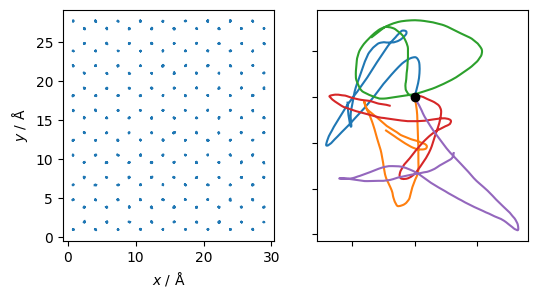

In [42]:
fig, axs = plt.subplots(1, 2, figsize=(6, 3))

# Total lattice
for i in range(900):
  if i % 5 == 0:
    axs[0].plot(trajectories[:,i,0], trajectories[:,i,1], color="C0")
axs[0].set_xlabel(r"$x$ / $\mathrm{Å}$")
axs[0].set_ylabel(r"$y$ / $\mathrm{Å}$")

# Zoomed 1 Atom
for i in range(5):
    axs[1].plot(trajectories[:,i,0]-trajectories[0,i,0], trajectories[:,i,1]-trajectories[0,i,1])
axs[1].plot(0, 0, "o", color="black")
axs[1].set_xticklabels([])
axs[1].set_yticklabels([])

plt.show()

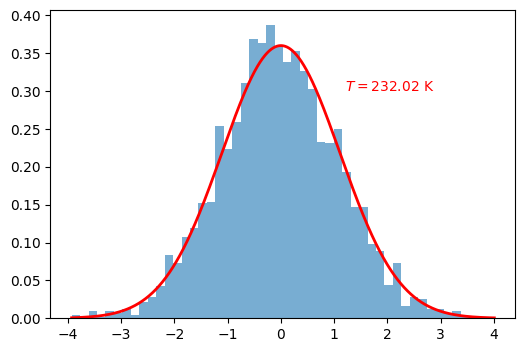

In [43]:
plt.figure(figsize=(6, 4))
plt.hist(velocities_history[-1].flatten(),bins=50, density=True, alpha=0.6, label='Simulation')

x = np.linspace(min(velocities_history[-1].flatten()), max(velocities_history[-1].flatten()), 1000)
scale = np.sqrt(k_B * energies["temperature"][-1] / (mass * u_to_eV))
plt.plot(x, np.exp(-x**2/(2*scale**2))/np.sqrt(2*np.pi*scale**2), 
             'r-', linewidth=2, label='Theoretical (Gaussian)')

plt.text(1.2, 0.3, f"$T={energies["temperature"][-1]:.2f}$ K", color="red")

plt.show()

The **position-position** autocorrelation function $C(t)$ is given by
$$
C(t) = \frac{\Delta t}{T - t} \sum_{0 < t' < T-t} \frac{1}{N} \sum^{N}_{i=1} \frac{\langle \vec{r}_i(t') \cdot \vec{r}_i(t'+t) \rangle - \langle \vec{r}_i(t) \rangle\cdot\langle \vec{r}_i(t) \rangle}{\langle \vec{r}_i(t) \cdot \vec{r}_i(t) \rangle - \langle \vec{r}_i(t) \rangle\cdot\langle \vec{r}_i(t) \rangle}
$$

In [84]:
def position_autocorrelation(r):
    T, N, _ = r.shape
    C_t = np.zeros(T)

    mean_norm = np.mean(np.sum(r * r, axis=2))  # ⟨r_i ⋅ r_i⟩

    for t in range(T):
        if T - t == 0:
            break  # Avoid division by zero
        
        # Compute the correlation for each t'
        correlations = np.sum(r[:T-t] * r[t:T], axis=(1, 2))  # Sum over N and 3D components
        mean_correlation = np.mean(correlations)  # ⟨r_i(t') ⋅ r_i(t' + t)⟩
        
        C_t[t] = (mean_correlation - mean_norm) / mean_norm

    return C_t

In [81]:
def position_autocorrelation(r):
    """
    Computes the normalized position-position autocorrelation function.
    
    Parameters:
    r : numpy.ndarray of shape (T, N, d)
        The position vectors of N particles over T discrete time steps in d dimensions.
    
    Returns:
    C_norm : numpy.ndarray of shape (T,)
        The normalized autocorrelation function C(tau) for each time lag tau, normalized so that C(0)=1.
    """
    T, N, d = r.shape
    C = np.zeros(T)
    
    # Compute the mean position for each time step (averaged over particles)
    r_mean = np.mean(r, axis=1)  # shape: (T, d)
    
    # Loop over time lags tau
    for tau in range(T):
        correlations = []
        # For each valid starting time t_prime, compute the dot product difference.
        for t_prime in range(T - tau):
            # Average dot product over all particles at times t_prime and t_prime+tau.
            dot_avg = np.einsum('nd,nd->', r[t_prime], r[t_prime + tau]) / N
            # Dot product of the mean positions at the two times.
            mean_dot = np.dot(r_mean[t_prime], r_mean[t_prime + tau])
            correlations.append(dot_avg - mean_dot)
        # Average over all starting times.
        C[tau] = np.mean(correlations)
    
    # Normalize so that C(0)=1 (C(0) is essentially the variance)
    if C[0] != 0:
        C_norm = C / C[0]
    else:
        C_norm = C
    return C_norm

In [85]:
ct = position_autocorrelation(trajectories)

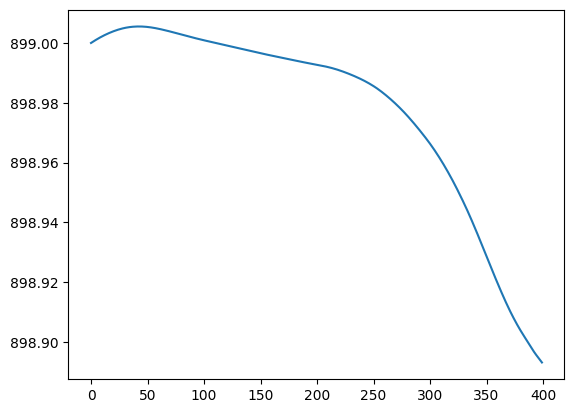

In [86]:
plt.plot(ct)